In [1]:
# Step 1: Set up necessary imports
import sqlite3
import pandas as pd
import operator
from typing import Annotated, TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START
import threading
from datetime import datetime, timedelta
import numpy as np

In [2]:
# Step 2: Create SQLite database and tables
def create_database():
    conn = sqlite3.connect('inventory_management.db')
    cursor = conn.cursor()

    # Create Warehouses table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS warehouses (
        warehouse_id INTEGER PRIMARY KEY,
        name TEXT,
        location TEXT,
        capacity INTEGER
    )''')

    # Create Products table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS products (
        product_id INTEGER PRIMARY KEY,
        name TEXT,
        category TEXT,
        unit_price DECIMAL(10,2),
        reorder_point INTEGER
    )''')

    # Create Inventory table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS inventory (
        warehouse_id INTEGER,
        product_id INTEGER,
        current_stock INTEGER,
        last_updated DATE,
        FOREIGN KEY (warehouse_id) REFERENCES warehouses(warehouse_id),
        FOREIGN KEY (product_id) REFERENCES products(product_id)
    )''')

    # Create Sales table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS sales (
        sale_id INTEGER PRIMARY KEY,
        warehouse_id INTEGER,
        product_id INTEGER,
        sale_date DATE,
        quantity INTEGER,
        FOREIGN KEY (warehouse_id) REFERENCES warehouses(warehouse_id),
        FOREIGN KEY (product_id) REFERENCES products(product_id)
    )''')

    conn.commit()
    conn.close()

create_database()

In [3]:
# Step 3: Insert sample data
def insert_sample_data():
    conn = sqlite3.connect('inventory_management.db')
    cursor = conn.cursor()

    # Insert Warehouses
    warehouses = [
        (1, 'North Hub', 'Seattle', 10000),
        (2, 'Central Distribution', 'Dallas', 15000),
        (3, 'East Coast Center', 'Atlanta', 12000)
    ]
    cursor.executemany('INSERT OR REPLACE INTO warehouses VALUES (?,?,?,?)', warehouses)

    # Insert Products
    products = [
        (1, 'Laptop Pro', 'Electronics', 999.99, 50),
        (2, 'Smartphone X', 'Electronics', 699.99, 75),
        (3, 'Wireless Earbuds', 'Electronics', 129.99, 100),
        (4, 'Smart Watch', 'Electronics', 299.99, 60),
        (5, 'Tablet Ultra', 'Electronics', 449.99, 40)
    ]
    cursor.executemany('INSERT OR REPLACE INTO products VALUES (?,?,?,?,?)', products)

    # Insert Inventory
    inventory = [
        (1, 1, 45, '2024-03-15'),
        (1, 2, 80, '2024-03-15'),
        (1, 3, 95, '2024-03-15'),
        (2, 1, 55, '2024-03-15'),
        (2, 2, 65, '2024-03-15'),
        (2, 4, 58, '2024-03-15'),
        (3, 3, 85, '2024-03-15'),
        (3, 4, 52, '2024-03-15'),
        (3, 5, 35, '2024-03-15')
    ]
    cursor.executemany('INSERT OR REPLACE INTO inventory VALUES (?,?,?,?)', inventory)

    # Insert Sales (last 30 days of sample data)
    sales = []
    for day in range(30):
        date = (datetime.now() - timedelta(days=day)).strftime('%Y-%m-%d')
        for _ in range(5):  # 5 random sales per day
            warehouse_id = np.random.randint(1, 4)
            product_id = np.random.randint(1, 6)
            quantity = np.random.randint(1, 10)
            sales.append((None, warehouse_id, product_id, date, quantity))

    cursor.executemany('INSERT INTO sales VALUES (?,?,?,?,?)', sales)

    conn.commit()
    conn.close()

insert_sample_data()

In [4]:
# Step 4: Create helper functions to fetch data
def get_warehouse_inventory(warehouse_id):
    conn = sqlite3.connect('inventory_management.db')
    query = '''
    SELECT
        w.name as warehouse_name,
        p.name as product_name,
        p.category,
        i.current_stock,
        p.reorder_point,
        (SELECT SUM(quantity)
         FROM sales s
         WHERE s.warehouse_id = w.warehouse_id
         AND s.product_id = p.product_id
         AND s.sale_date >= date('now', '-30 days')
        ) as monthly_sales
    FROM inventory i
    JOIN warehouses w ON i.warehouse_id = w.warehouse_id
    JOIN products p ON i.product_id = p.product_id
    WHERE w.warehouse_id = ?
    '''
    df = pd.read_sql_query(query, conn, params=[warehouse_id])
    conn.close()
    return df

def get_all_warehouses():
    conn = sqlite3.connect('inventory_management.db')
    df = pd.read_sql_query('SELECT * FROM warehouses', conn)
    conn.close()
    return df.warehouse_id.tolist()

In [5]:
# Step 5: Define our data models and states
class WarehouseAnalysis(BaseModel):
    recommendations: list[str]

class FinalPlan(BaseModel):
    priority_plan: str

class OverallState(TypedDict):
    category: str
    warehouses: list
    recommendations: Annotated[list, operator.add]
    final_plan: str

class WarehouseState(TypedDict):
    warehouse_id: int

In [6]:
# Step 6: Define processing functions
def analyze_warehouse(state: WarehouseState):
    """Analyze individual warehouse inventory and generate recommendations"""
    thread_name = threading.current_thread().name
    print(f"Thread: {thread_name} - Analyzing warehouse: {state['warehouse_id']}")

    # Get warehouse data
    df = get_warehouse_inventory(state['warehouse_id'])

    recommendations = []
    for _, row in df.iterrows():
        monthly_sales = row['monthly_sales'] if row['monthly_sales'] else 0
        if row['current_stock'] < row['reorder_point']:
            recommendations.append(
                f"URGENT: Restock {row['product_name']} at {row['warehouse_name']}. "
                f"Current stock: {row['current_stock']}, Reorder point: {row['reorder_point']}"
            )
        elif row['current_stock'] < monthly_sales:
            recommendations.append(
                f"WARNING: Low stock for {row['product_name']} at {row['warehouse_name']}. "
                f"Current stock ({row['current_stock']}) is below monthly sales ({monthly_sales})"
            )

    return {"recommendations": recommendations}

def continue_to_analysis(state: OverallState):
    """Map function to distribute warehouse analysis"""
    thread_name = threading.current_thread().name
    print(f"Thread: {thread_name} - Distributing warehouse analysis tasks")
    warehouses = get_all_warehouses()

    # Initialize the state with required fields
    return {
        "category": "inventory",  # Add a default category
        "warehouses": warehouses,
        "recommendations": [],    # Initialize empty recommendations list
        "final_plan": "",        # Initialize empty final plan
        "next": [Send("analyze_warehouse", {"warehouse_id": w}) for w in warehouses]
    }
def create_final_plan(state: OverallState):
    """Create final consolidated plan"""
    thread_name = threading.current_thread().name
    print(f"Thread: {thread_name} - Creating final plan")

    # Sort recommendations by priority (URGENT first, then WARNING)
    urgent_items = [r for r in state["recommendations"] if r.startswith("URGENT")]
    warning_items = [r for r in state["recommendations"] if r.startswith("WARNING")]

    final_plan = "Priority Restocking Plan:\n\n"
    final_plan += "URGENT ACTIONS:\n" + "\n".join(urgent_items) + "\n\n"
    final_plan += "WARNINGS:\n" + "\n".join(warning_items)

    return {"final_plan": final_plan}

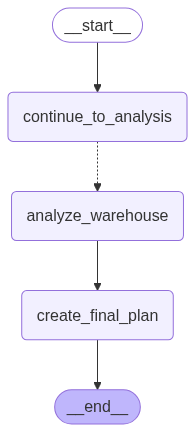

In [7]:
# Step 7: Create and configure the graph
graph = StateGraph(state_schema=OverallState)

# Add nodes
graph.add_node("continue_to_analysis", continue_to_analysis)
graph.add_node("analyze_warehouse", analyze_warehouse)
graph.add_node("create_final_plan", create_final_plan)

# Add edges
graph.add_edge(START, "continue_to_analysis")
graph.add_conditional_edges(
    "continue_to_analysis",
    lambda x: x["next"],
    ["analyze_warehouse"]
)
graph.add_edge("analyze_warehouse", "create_final_plan")
graph.add_edge("create_final_plan", END)

# Compile the graph
app = graph.compile()

from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [8]:
# Step 8: Execute the graph
result = app.invoke({
    "category": "",
    "warehouses": [],
    "recommendations": [],
    "final_plan": ""
})
print("\nFinal Restocking Plan:")
print(result['final_plan'])

Thread: MainThread - Distributing warehouse analysis tasks
Thread: ThreadPoolExecutor-1_0 - Analyzing warehouse: 1
Thread: ThreadPoolExecutor-1_1 - Analyzing warehouse: 2
Thread: ThreadPoolExecutor-1_2 - Analyzing warehouse: 3
Thread: MainThread - Creating final plan

Final Restocking Plan:
Priority Restocking Plan:

URGENT ACTIONS:
URGENT: Restock Laptop Pro at North Hub. Current stock: 45, Reorder point: 50
URGENT: Restock Wireless Earbuds at North Hub. Current stock: 95, Reorder point: 100
URGENT: Restock Laptop Pro at North Hub. Current stock: 45, Reorder point: 50
URGENT: Restock Wireless Earbuds at North Hub. Current stock: 95, Reorder point: 100
URGENT: Restock Smartphone X at Central Distribution. Current stock: 65, Reorder point: 75
URGENT: Restock Smart Watch at Central Distribution. Current stock: 58, Reorder point: 60
URGENT: Restock Smartphone X at Central Distribution. Current stock: 65, Reorder point: 75
URGENT: Restock Smart Watch at Central Distribution. Current stock: